In [1]:
import numpy as np
import subprocess
import os
import glob
import yaml
import xarray as xr
import math
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import osprey_io as io
import osprey_means as osm
import osprey_actions as osa

In [2]:
#rdata = osa.forecast_T_local_fit('lf00', 21, 10, 10, True, True)

In [2]:
#
expname='lf01'
leg=301
yearspan=5
yearleap=10
#
endyear = 1990+int(leg)-2
startyear = endyear - yearspan
xf = endyear+yearleap
data = io.readmf_T(expname, startyear, endyear)
x = osm.dateDecimal(data['time'].values.flatten())
ds = data['to'].isel(time=0)
ds_flat = ds.values.flatten()
to_flat = data['to'].values.flatten()
to_reshaped = to_flat.reshape(len(x),-1)
indices = ~np.isnan(to_reshaped)
indices_flat = ~np.isnan(to_flat)
to_valid = to_flat[indices_flat]
size_valid = to_valid.shape[0]/len(x)
to_wonan = np.zeros((len(x), int(size_valid)))
to_wonan = to_reshaped[:, indices[0]]

In [3]:
check_fit = True
if check_fit:
    j=random.randint(0, to_wonan.shape[1]-1)
to_pred = []
model = LinearRegression()
for i in range(to_wonan.shape[1]):
    x_row = np.array(x).reshape(len(x),-1)
    y_row = to_wonan[:, i].reshape(len(x),-1)
    model.fit(x_row, y_row)
    mp = model.coef_[0][0]
    qp = model.intercept_[0]
    yf = model.predict([[xf]])    
    to_pred.append(yf[0][0])
    if check_fit and i == j:
        xrow=x_row; yrow=y_row
        mm=mp; qq=qp; yy=yf

In [4]:
y_last = []
for i in range(to_wonan.shape[1]):
    y_last.append(to_wonan[-1, i])
k=0
for i in range(len(to_pred)):
    if to_pred[i] < -1.8:
        to_pred[i] = y_last[i]
        k += 1
print(' Fraction of points below -2deg = ',k/len(to_pred))

 Fraction of points below -2deg =  0.0720470465820621


In [5]:
k=0
deltaTave = 0.0
deltaT = []
for i in range(len(to_pred)):
    k += 1
    deltaT.append(to_pred[i]-y_last[i])
    deltaTave += abs(y_last[i]-to_pred[i]) 
deltaTave = deltaTave/k

In [6]:
deltaTave

1.2461123774914058

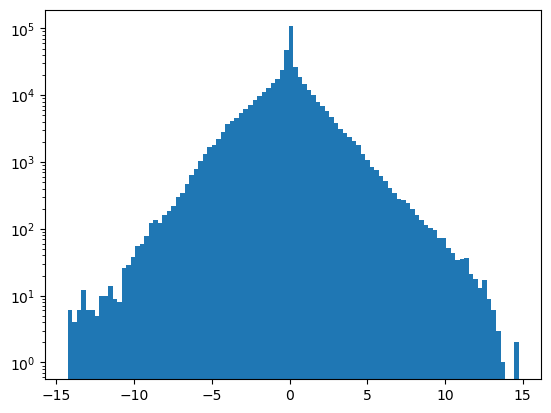

In [7]:
plt.hist(deltaT, bins=100)
plt.yscale('log')
plt.show()

In [17]:
theta = []
j = 0
for i in range(len(ds_flat)):
    if indices[0][i]:
        theta.append(to_pred[j])
        j += 1
    else:
        theta.append(np.nan)
te = np.array(theta).reshape((len(ds['z']),len(ds['y']),len(ds['x'])))

In [18]:
rdata = io.read_restart(expname, leg)
varlist = ['tn', 'tb']
for var in varlist:
    rdata[var] = xr.where(rdata[var]!=0.0, te, 0.0)

In [ ]:
# average of predicted temperature


AttributeError: 'DataArray' object has no attribute 'rename_dim'

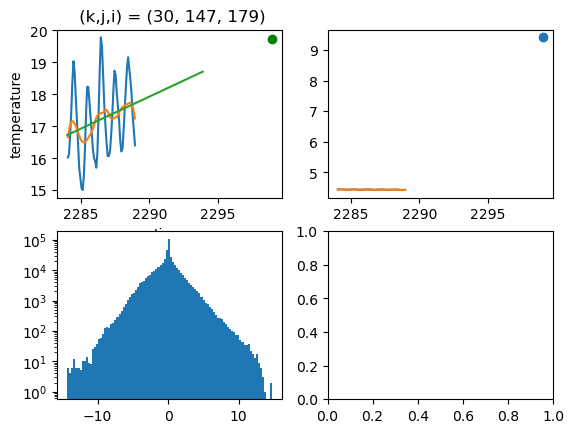

In [19]:
if check_fit:
    fig, axs = plt.subplots(2, 2)
    # figure 1: check local fit by random picking
    kji = osm.flatten_to_triad(i, 31, 148, 180)
    if yy < -1.8:
        yy = yrow[-1]
    ym = osm.movave(yrow.flatten(),12).reshape(len(xrow),-1)
    yp = []; xp = []
    for i in range(len(xrow)*2):
        xp.append(startyear+i/12.)
        yp.append(mm*(startyear+i/12.)+qq)    
    axs[0,0].plot(xrow,yrow)
    axs[0,0].plot(x,ym)
    axs[0,0].plot(xp,yp)
    axs[0,0].scatter(xf,yy, color='green')
    axs[0,0].set_ylabel('temperature')
    axs[0,0].set_xlabel('time')    
    axs[0,0].set_title(' (k,j,i) = {}'.format(kji))
    #axs[0,0].plt.gca().legend(('local trend','moving average','fit','projected value'))
    # figure 2: pdf of ΔT_forecast
    k=0
    deltaTave = 0.0
    deltaT = []
    for i in range(len(to_pred)):
        k += 1
        deltaT.append(to_pred[i]-y_last[i])
        deltaTave += abs(y_last[i]-to_pred[i]) 
    deltaTave = deltaTave/k
    axs[1,0].hist(deltaT, bins=100)
    axs[1,0].set_yscale('log')
    # figure 3: global trend & fit
    df = osm.elements(expname=expname)
    vv = data['to'].weighted(df['vol']).mean(dim=['z', 'y', 'x']).values.flatten()
    ymg = osm.movave(vv,12)
    k=0
    to_pred_ave = 0.0
    for i in range(len(to_pred)):
        k += 1
        to_pred_ave += to_pred[i] 
    tog = to_pred_ave/k
    axs[0,1].plot(x,vv)
    axs[0,1].plot(x,ymg)
    axs[0,1].scatter(xf,tog)
    # figure 4
    df['vol'] = df['vol'].rename_dim('z', 'nav_lev')
    rdata0 = io.read_restart(expname, leg)
    tn_ave = data['tn'].weighted(df['vol']).mean(dim=['nav_lev', 'y', 'x']).values.flatten()
    dd = xr.where(rdata0['tn']!=0, rdata['tn'].values-rdata0['tn'].values, 0.0)
    zlev=0
    dd.isel(time_counter=0,nav_lev=zlev).plot()
    plt.title(' z = {}'.format(zlev))
    fig.savefig('check.png')
    

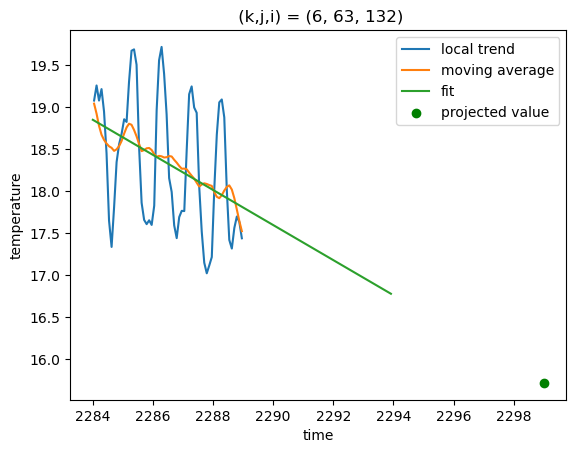

In [10]:
check_fit=True
if check_fit:
    i=random.randint(0, to_wonan.shape[1]-1)
    kji = osm.flatten_to_triad(i, 31, 148, 180)
    model = LinearRegression()
    x_row = np.array(x).reshape(len(x),-1)
    y_row = to_wonan[:,i].reshape(len(x),-1)
    model.fit(x_row, y_row)
    mp = model.coef_[0][0]
    qp = model.intercept_[0]
    yf = model.predict([[xf]])
    if yf < -1.8:
        yf = y_row[-1]
    ym = osm.movave(y_row.flatten(),12).reshape(len(x),-1)
    yp = []; xp = []
    for i in range(len(x)*2):
        xp.append(startyear+i/12.)
        yp.append(mp*(startyear+i/12.)+qp)    
    plt.plot(x_row,y_row)
    plt.plot(x,ym)
    plt.plot(xp,yp)
    plt.scatter(xf,yf, color='green')
    plt.ylabel('temperature')
    plt.xlabel('time')
    plt.title('')
    plt.title(' (k,j,i) = {}'.format(kji))
    plt.gca().legend(('local trend','moving average','fit','projected value'))
    plt.savefig('check.png')

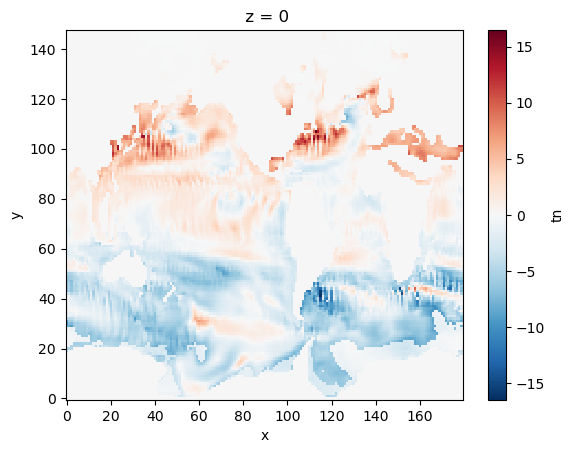

In [11]:
check_map=True
if check_map:
    rdata0 = io.read_restart(expname, leg)
    dd = xr.where(rdata0['tn']!=0, rdata['tn'].values-rdata0['tn'].values, 0.0)
    #fig = plt.figure(figsize=(1,1), dpi=300)
    #ax = fig.add_subplot(111)
    zlev=0
    dd.isel(time_counter=0,nav_lev=zlev).plot()
    plt.title(' z = {}'.format(zlev))
    #fig.savefig('check_map.png', bbox_inches='tight')

In [12]:
df = osm.elements(expname='lfr0')  
xdata = io.read_T(expname='lfr0', year=xf)
mdata = xdata['to'].mean('time')
ndata = xr.where(mdata!=0.0, te, 0.0)
delta2 = xr.where(mdata!=0.0, pow(ndata.values-mdata.values,2), 0.0)
err = delta2.weighted(df['vol']).mean(dim=['z', 'y', 'x']).values
err[0]

3.288832585365916

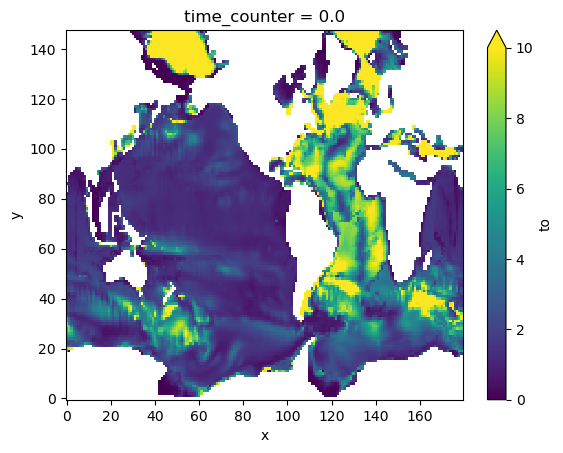

In [13]:
delta2.weighted(df['dz']).mean(dim='z').plot(vmin=0,vmax=10)

In [2]:
# timeseries of error forecast / cost function
expname='lf01'
dirs = io.folders(expname)
df = osm.elements(expname)
df['vol'] = df['vol'].mean('time_counter').rename({'z': 'nav_lev'})
deltamean1 = []
legs=361
x1 = [leg for leg in range(11,legs,10)]
for leg in range(11,legs,10):
    print(leg)
    filename2 = os.path.join(dirs['tmp'], str(leg).zfill(3), 'restart.nc')
    data2 = xr.open_mfdataset(filename2)
    filename1 = os.path.join(dirs['tmp'], str(leg).zfill(3), expname + '*_restart.nc')
    data1 = xr.open_mfdataset(filename1)
    xdata1 = data1.mean('time_counter')
    xdata2 = data2.mean('time_counter')
    delta1 = xr.where(xdata1['tn']!=0.0, (xdata1['tn'].values-xdata2['tn'].values), 0.0)
    appo = delta1.weighted(df['vol']).mean(dim=['nav_lev', 'y', 'x']).values.flatten()
    deltamean1.append(appo[0])

11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351


In [88]:
# timeseries of error forecast / cost function
expname='lf02'
dirs = io.folders(expname)
df = osm.elements(expname)
df['vol'] = df['vol'].mean('time_counter').rename({'z': 'nav_lev'})
deltamean2 = []
legs=211
x2 = [leg for leg in range(11,legs,10)]
for leg in range(11,legs,10):
    print(leg)
    filename2 = os.path.join(dirs['tmp'], str(leg).zfill(3), 'restart.nc')
    data2 = xr.open_mfdataset(filename2)
    filename1 = os.path.join(dirs['tmp'], str(leg).zfill(3), expname + '*_restart.nc')
    data1 = xr.open_mfdataset(filename1)
    xdata1 = data1.mean('time_counter')
    xdata2 = data2.mean('time_counter')
    delta2 = xr.where(xdata1['tn']!=0.0, (xdata1['tn'].values-xdata2['tn'].values), 0.0)
    appo = delta2.weighted(df['vol']).mean(dim=['nav_lev', 'y', 'x']).values.flatten()
    deltamean2.append(appo[0])

11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201


Text(0.5, 1.0, 'Forecast Error - Cost function')

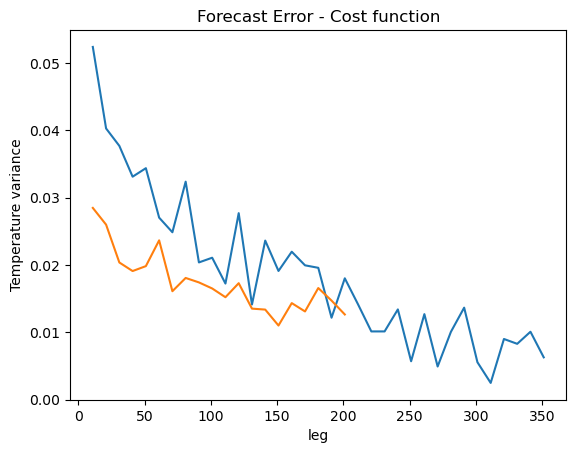

In [89]:
plt.plot(x1,deltamean1)
plt.plot(x2,deltamean2)
plt.xlabel('leg')
plt.ylabel('Temperature variance')
plt.title('Forecast Error - Cost function')

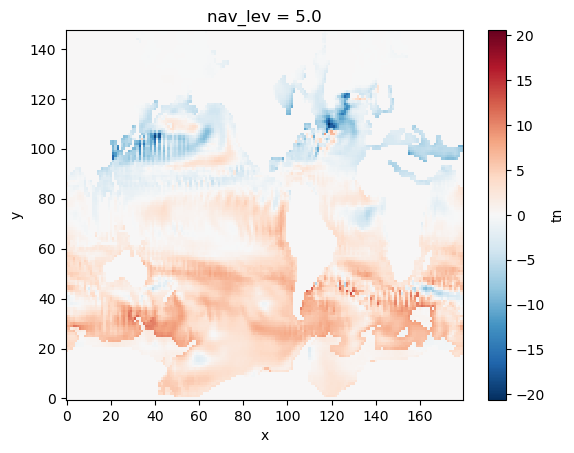

In [77]:
delta1.isel(nav_lev=0).plot()

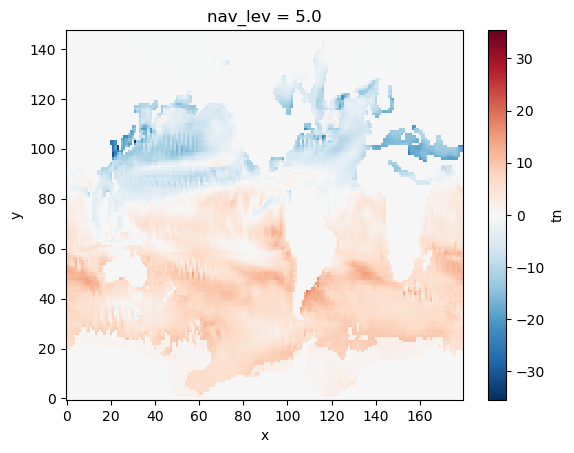

In [78]:
delta2.isel(nav_lev=0).plot()

In [91]:
delta1

<xarray.DataArray 'tn' (nav_lev: 31, y: 148, x: 180)>
dask.array<where, shape=(31, 148, 180), dtype=float64, chunksize=(1, 135, 180), chunktype=numpy.ndarray>
Coordinates:
  * nav_lev  (nav_lev) float32 5.0 15.0 25.0 ... 4.25e+03 4.75e+03 5.25e+03
Dimensions without coordinates: y, x

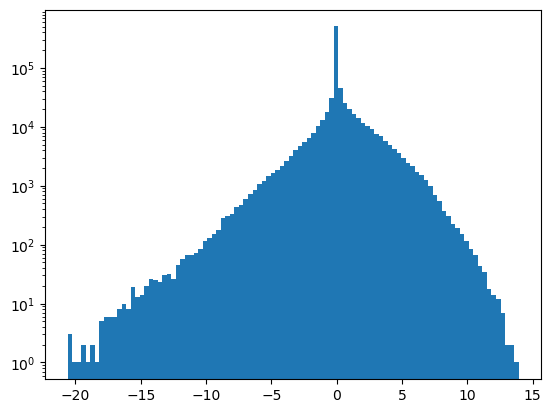

In [92]:
plt.hist(delta1.values.flatten(), bins=100)
plt.yscale('log')
plt.show()

In [2]:
# concatenate restart fields
expname='lf01'
dirs = io.folders(expname)
df = osm.elements(expname)
df['vol'] = df['vol'].rename({'z': 'nav_lev'})
filelist1 = []
filelist2 = []
deltamean1 = []
legs=361
x2 = [leg for leg in range(11,legs-10,10)]
for leg in range(11,legs,10):
    pattern1 = os.path.join(dirs['tmp'], str(leg).zfill(3), 'restart.nc')
    matching_files1 = glob.glob(pattern1)
    filelist1.extend(matching_files1)
    pattern2 = os.path.join(dirs['tmp'], str(leg).zfill(3), expname + '*_restart.nc')
    matching_files2 = glob.glob(pattern2)
    filelist2.extend(matching_files2)
data2 = xr.open_mfdataset(filelist2) 
data1 = xr.open_mfdataset(filelist1)

In [3]:
delta1 = xr.where(data1['tn']!=0.0, (data2['tn'].values-data1['tn'].values), 0.0)
delta1['time_counter'] = xr.where(data1['time_counter'], x2, 0.0)

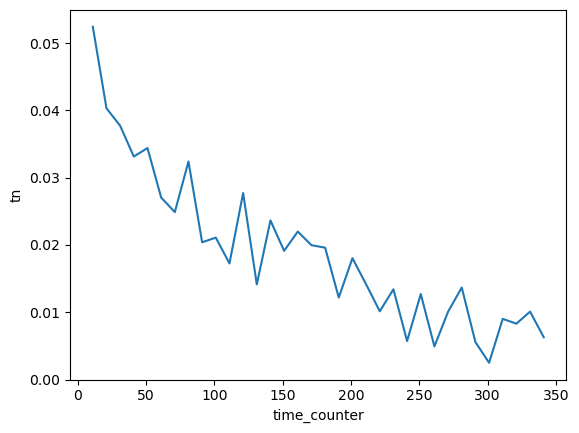

In [4]:
df = osm.elements(expname)
df['vol'] = df['vol'].mean('time_counter').rename({'z': 'nav_lev'})
delta1.weighted(df['vol']).mean(dim=['nav_lev', 'y', 'x']).plot()

/etc/ecmwf/nfs/dh2_perm_b/itas/micromamba/envs/stece/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


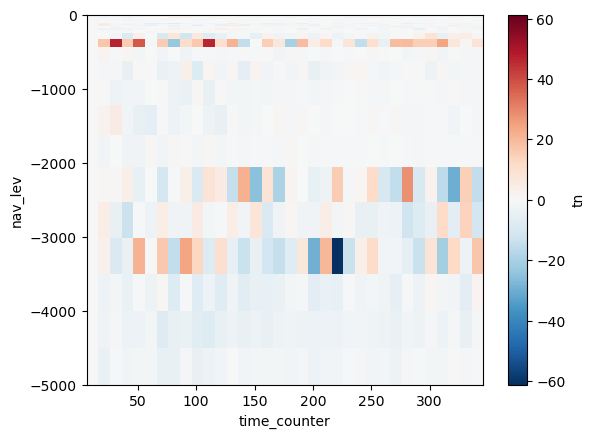

In [5]:
# hovmoller
df['area'] = df['area'].mean('time_counter')
deltavar1 = xr.where(delta1.isel(time_counter=0)!=0.0, delta1/delta1.isel(time_counter=0)-1.0,0.0) 
hovm = deltavar1.weighted(df['area']).mean(dim=['y', 'x'])
hovm.coords['nav_lev'] = -hovm['nav_lev']  
hovm.plot(y='nav_lev', ylim=(-5000, 0))

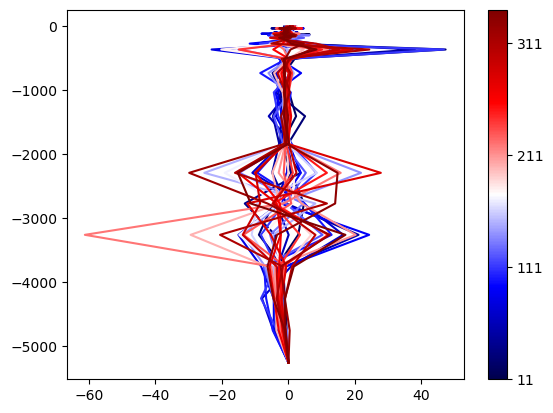

In [8]:
# vertical profiles
fig = plt.figure()
ax = fig.add_subplot(111)
ca = hovm['time_counter'].values.flatten()
cmap = plt.get_cmap("jet", len(ca))
norm = plt.Normalize(min(ca),max(ca))
cmap = plt.get_cmap('seismic')
c = cmap(norm(ca))
for i in range(1,len(ca)):
    xa = hovm.isel(time_counter=i).values.flatten()
    ya = hovm['nav_lev'].values.flatten()
    ax.plot(xa, ya, c=c[i])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, ticks=[11,111,211,311])

In [5]:
# cost function / measure of distance from equilibrium (lfr5: 2150-2350)
mfield = osm.mean_state('lfr5', 2150, 2350)

In [6]:
mfield

<xarray.Dataset>
Dimensions:        (y: 148, x: 180, z: 31, axis_nbounds: 2)
Coordinates:
    nav_lat        (y, x) float32 dask.array<chunksize=(148, 180), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(148, 180), meta=np.ndarray>
  * z              (z) float32 -5.0 -15.0 -25.0 ... -4.75e+03 -5.25e+03
Dimensions without coordinates: y, x, axis_nbounds
Data variables: (12/23)
    deptht_bounds  (z, axis_nbounds) float32 dask.array<chunksize=(31, 2), meta=np.ndarray>
    e3t            (z, y, x) float32 dask.array<chunksize=(31, 148, 180), meta=np.ndarray>
    to             (z, y, x) float32 dask.array<chunksize=(31, 148, 180), meta=np.ndarray>
    so             (z, y, x) float32 dask.array<chunksize=(31, 148, 180), meta=np.ndarray>
    tos            (y, x) float32 dask.array<chunksize=(148, 180), meta=np.ndarray>
    sos            (y, x) float32 dask.array<chunksize=(148, 180), meta=np.ndarray>
    ...             ...
    qt_oce         (y, x) float32 dask.array<chunksize=(148, 180), meta=np.ndarray>
    sfx            (y, x) float32 dask.array<chunksize=(148, 180), meta=np.ndarray>
    taum           (y, x) float32 dask.array<chunksize=(148, 180), meta=np.ndarray>
    windsp         (y, x) float32 dask.array<chunksize=(148, 180), meta=np.ndarray>
    precip         (y, x) float32 dask.array<chunksize=(148, 180), meta=np.ndarray>
    snowpre        (y, x) float32 dask.array<chunksize=(148, 180), meta=np.ndarray>

In [7]:
nfield = mfield.drop_dims({'axis_nbounds'})

In [8]:
nfield

<xarray.Dataset>
Dimensions:      (y: 148, x: 180, z: 31)
Coordinates:
    nav_lat      (y, x) float32 dask.array<chunksize=(148, 180), meta=np.ndarray>
    nav_lon      (y, x) float32 dask.array<chunksize=(148, 180), meta=np.ndarray>
  * z            (z) float32 -5.0 -15.0 -25.0 ... -4.25e+03 -4.75e+03 -5.25e+03
Dimensions without coordinates: y, x
Data variables: (12/22)
    e3t          (z, y, x) float32 dask.array<chunksize=(31, 148, 180), meta=np.ndarray>
    to           (z, y, x) float32 dask.array<chunksize=(31, 148, 180), meta=np.ndarray>
    so           (z, y, x) float32 dask.array<chunksize=(31, 148, 180), meta=np.ndarray>
    tos          (y, x) float32 dask.array<chunksize=(148, 180), meta=np.ndarray>
    sos          (y, x) float32 dask.array<chunksize=(148, 180), meta=np.ndarray>
    zos          (y, x) float32 dask.array<chunksize=(148, 180), meta=np.ndarray>
    ...           ...
    qt_oce       (y, x) float32 dask.array<chunksize=(148, 180), meta=np.ndarray>
    sfx          (y, x) float32 dask.array<chunksize=(148, 180), meta=np.ndarray>
    taum         (y, x) float32 dask.array<chunksize=(148, 180), meta=np.ndarray>
    windsp       (y, x) float32 dask.array<chunksize=(148, 180), meta=np.ndarray>
    precip       (y, x) float32 dask.array<chunksize=(148, 180), meta=np.ndarray>
    snowpre      (y, x) float32 dask.array<chunksize=(148, 180), meta=np.ndarray>

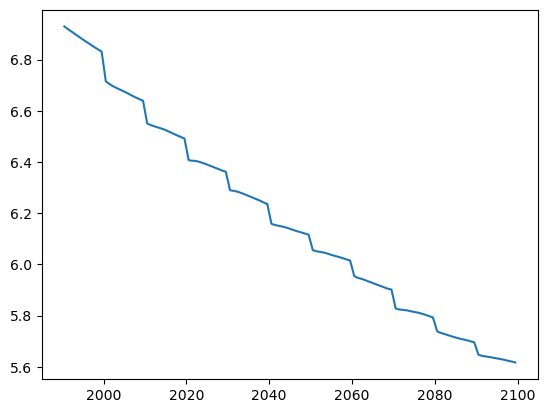

In [2]:
df = osm.elements('lf01')
data = io.readmf_T('lf01', 1990, 2100)
tt = osm.dateDecimal(data['time'].values)
vv = osm.movave(data['to'].weighted(df['vol']).mean(dim=['z', 'y', 'x']).values.flatten(),12)
tt1 = tt[6:-6]; vv1 = vv[6:-6]
plt.plot(tt1,vv1)

In [3]:
data

<xarray.Dataset>
Dimensions:               (y: 148, x: 180, time: 1320, z: 31, axis_nbounds: 2)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(148, 180), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(148, 180), meta=np.ndarray>
    time_centered         (time) object dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) object 1990-01-16 12:00:00 ... 2099-12-16 12...
  * z                     (z) float32 -5.0 -15.0 -25.0 ... -4.75e+03 -5.25e+03
Dimensions without coordinates: y, x, axis_nbounds
Data variables: (12/25)
    deptht_bounds         (time, z, axis_nbounds) float32 dask.array<chunksize=(12, 31, 2), meta=np.ndarray>
    time_centered_bounds  (time, axis_nbounds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    e3t                   (time, z, y, x) float32 dask.array<chunksize=(1, 31, 148, 180), meta=np.ndarray>
    to                    (time, z, y, x) float32 dask.array<chunksize=(1, 31, 148, 180), meta=np.ndarray>
    so                    (time, z, y, x) float32 dask.array<chunksize=(1, 31, 148, 180), meta=np.ndarray>
    ...                    ...
    qt_oce                (time, y, x) float32 dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    sfx                   (time, y, x) float32 dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    taum                  (time, y, x) float32 dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    windsp                (time, y, x) float32 dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    precip                (time, y, x) float32 dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    snowpre               (time, y, x) float32 dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
Attributes:
    name:         output/nemo/lf01_oce_1m_T
    description:  ECE4/NEMO T grid variables
    title:        ECE4/NEMO T grid variables
    Conventions:  CF-1.6
    timeStamp:    2024-Apr-12 08:37:07 GMT
    uuid:         4aef3c07-c05d-45ae-8732-487fb47a7c18

In [4]:
hdata = data.drop_dims({'axis_nbounds'})

In [9]:
gdata = hdata - nfield

: 

In [20]:
gdata

<xarray.Dataset>
Dimensions:        (y: 148, x: 180, time: 4440, z: 31)
Coordinates:
    nav_lat        (y, x) float32 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    nav_lon        (y, x) float32 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    time_centered  (time) object dask.array<chunksize=(1,), meta=np.ndarray>
  * time           (time) object 1990-01-16 12:00:00 ... 2359-12-16 12:00:00
  * z              (z) float32 -5.0 -15.0 -25.0 ... -4.75e+03 -5.25e+03
Dimensions without coordinates: y, x
Data variables: (12/22)
    e3t            (time, z, y, x) float32 dask.array<chunksize=(1, 31, 148, 180), meta=np.ndarray>
    to             (time, z, y, x) float32 dask.array<chunksize=(1, 31, 148, 180), meta=np.ndarray>
    so             (time, z, y, x) float32 dask.array<chunksize=(1, 31, 148, 180), meta=np.ndarray>
    tos            (time, y, x) float32 dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    sos            (time, y, x) float32 dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    zos            (time, y, x) float32 dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    ...             ...
    qt_oce         (time, y, x) float32 dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    sfx            (time, y, x) float32 dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    taum           (time, y, x) float32 dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    windsp         (time, y, x) float32 dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    precip         (time, y, x) float32 dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    snowpre        (time, y, x) float32 dask.array<chunksize=(1, 148, 180), meta=np.ndarray>

In [21]:
gdata['to'].weighted(df['vol']).mean(dim=['z', 'y', 'x']).values.flatten()

: 